In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from numpy.fft import fft,ifft,rfft,irfft
import scipy.signal as sig
from scipy.interpolate import interp1d

We're going to simulate data discretely sampled in time. We need to set a sample rate in Hz. The highest resolvable frequency, the Nyquist frequency, is half the sample rate. We also need to decide how long the simulated data record should last.

Note that we'll assume everything is real in the time domain, so we use rFFT and rIFFT. That just means that we're only keeping positive frequencies in the frequency domain.

In [7]:
sample_rate = 4096
nyquist = sample_rate/2
time_length_seconds = 512

## Generate fake Gaussian noise

We'll start by making some fake noise to practice on. The procedure for making colored Gaussian noise is:
 1. Generate white Gaussian noise by many independent draws from a normal distribution.
 1. Transform this to the frequency domain.
 1. Choose the spectrum you want to simulate, sampled at the same frequencies as the frequency-domain white noise.
 1. Multiply the FD white noise by the ASD of the desired spectrum.
 1. Transform this back to the time domain.
 1. Cut off the start and end of this data, to eliminate the filter wraparond. We cut off a quarter of the noise stream at either end, which should be more than enough with such a smooth PSD.

In [8]:
# Make the data twice as long so we can cut off the wrap-around
num_noise_samples=2*time_length_seconds*sample_rate
white_noise_fd=rfft(np.random.normal(size=num_noise_samples))
sim_freqs=np.arange(len(white_noise_fd))/(2.*time_length_seconds)

We'll make an analytical PSD that has about the same shape as H1's noise. We put in a fake highpass filter around 8 Hz so we don't have infinite noise at low frequency, and to match what the calibration code does (it only reconstructs accurately above 10 Hz).

In [9]:
psd=(sim_freqs/40.)**-10+(sim_freqs/70.)**-4+0.5+1.397e-6*(sim_freqs)**2
# Put in a fake highpass around 8 Hz, so we don't have too much low frequency
to_bin=2*time_length_seconds
f_pass, f_min = 8., 10.
idx1=int(to_bin*f_pass)
idx2=int(to_bin*f_min)
psd[:idx1]=psd[idx2]*(sim_freqs[:idx1]/f_pass)**2
psd[idx1:idx2]=psd[idx2]

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


In [10]:
# Generate the noise
colored_noise_td = np.sqrt(float(nyquist))*irfft(np.sqrt(psd)*white_noise_fd)
colored_noise_td = colored_noise_td[len(colored_noise_td)/4:-len(colored_noise_td)/4]

In [11]:
def welch_asd(data, fft_len_sec, overlap=0.5, window='hanning'):
    """Measure the ASD using the Welch method of averaging
    estimates on shorter overlapping segments of the data."""
    assert 0. <= overlap < 1.
    ff, tmp = sig.welch(data, fs=sample_rate, window=window,
                        nperseg=fft_len_sec*sample_rate,
                        noverlap=overlap*fft_len_sec*sample_rate)
    return ff, np.sqrt(tmp)

In [12]:
ff, measured_asd = welch_asd(colored_noise_td, window='hanning', fft_len_sec=4)

(0.5, 2000.0)

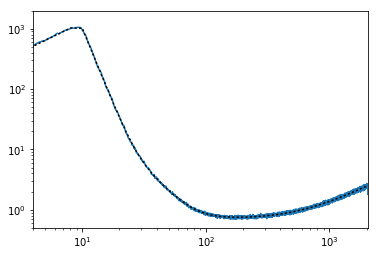

In [13]:
plt.loglog(ff, measured_asd)
plt.loglog(sim_freqs, np.sqrt(psd), c='k', ls=':')
plt.xlim(4,nyquist)
plt.ylim(0.5,2e3)

## Make a whitening filter

We need to make a whitening filter for the data. This is an FIR filter that, when applied to our colored noise, produces a decorrelated or 'white' time series. There are many ways to calculate this, and actually many different filters that would achieve this. We'll choose to make ours zero-phase -- the impulse response is acausal and symmetric around t=0. We'll use FFT-based methods for the design because they are simple and efficient.

First, we make a good estimate of the ASD, with enough frequency resolution to capture the important features. Then we do 1/asd to get a rough whitening filter. We zero out any frequencies we want to throw away (in this case, below 10 Hz because strain is not accurate down there). We transform to the time domain to get an impulse response, and roll it forwards so the response is centered at half the length of the filter.

Then we truncate it with a window function to make sure that it goes to zero smoothly. This is our time-domain FIR filter. The t=0 of this acausal filter is still in the middle, so make sure to compensate for the filter delay if using it this way.

The inverting and Fourier transforming it part may not be quite the best thing to do. Even better might be to measure the ASD at the desired resolution, then interpolate to higher resolution. That gives more space when computing the impulse response to avoid wraparound issues. The details of the interpolation shouldn't matter since you're truncating it anyway.

In [16]:
def make_invasd(data, invasd_len=8, f_min=10.):
    """invasd_len is the length in seconds of the desired impulse response (the full width)"""
    ff, asd = welch_asd(data, window='hanning', fft_len_sec=invasd_len)
    invasd = 1./asd
    invasd[:int(f_min*invasd_len)]=0.
    invasd_td = irfft(invasd)
    invasd_td = sig.hann(len(invasd_td))*np.roll(invasd_td, len(invasd_td)/2)
    return invasd_td

In [17]:
invasd_len=8
invasd_trunc = make_invasd(colored_noise_td, invasd_len=invasd_len, f_min=10.)

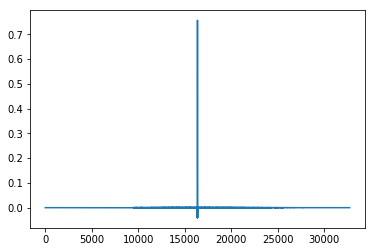

In [18]:
plt.plot(invasd_trunc)

To apply the filter efficiently, we can pad it with zeros to the length of the data then transform it to the frequency domain. We could either compensate for the time delay explicitly, or just take the absolute value of the filter which will make it zero-phase. We multiply this by the FFT of the data, and IFFT them back.

This is completely equivalent to just applying the FIR filter by convolution in the time domain.

In [21]:
tmp = invasd_trunc.copy()
tmp.resize(len(colored_noise_td))
fd_filter=np.abs(rfft(tmp))
whitened_strain_corrupt = irfft(fd_filter*rfft(colored_noise_td))

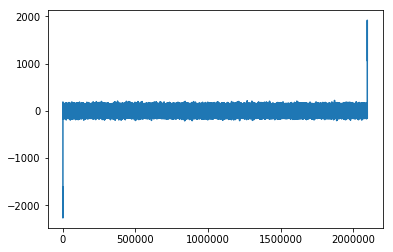

In [22]:
plt.plot(whitened_strain_corrupt)

Here, I've left the filter corruption on. We need to remove half the total length of the filter on both sides because of the filter wrapround. 

In [23]:
whitened_strain_corrupt = whitened_strain[invasd_len*sample_rate/2:-invasd_len*sample_rate/2]

Now we can check the spectrum of the whitened data. It should be flat, at least where the assumptions in deriving the filter are valid.

(0.1, 10)

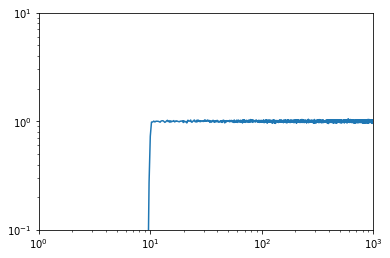

In [25]:
ff, asdw = welch_asd(whitened_strain, window='hanning', fft_len_sec=4)
plt.loglog(ff, asdw)
plt.xlim(1,1000)
plt.ylim(0.1,10)

Perfectly flat everywhere, with the data below 10 Hz removed.

The line is completely removed, but the rest of the data is affected as well. To only notch around the line would require either a much more complicated FIR filter, or a simple IIR filter with poles to cancel the zeroes when not close to the line.